In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pickle

In [2]:
def get_r(x, y):
    return np.sqrt(x * x + y * y)

def get_r2(x, y):
    return x * x + y * y

def get_theta(x, y):
    return np.arctan(x / y)

def get_phi(x, y):
    return np.arctan(y / x)


    
def v_linear(x, y):
    return (x, y)

def v_sinusoidal(x, y):
    return (np.sin(x), np.sin(y))

def v_spherical(x, y):
    r2 = get_r2(x, y)
    return (x / r2, y / r2)

def v_swirl(x, y):
    r2 = get_r2(x, y)
    sin_r2 = np.sin(r2)
    cos_r2 = np.cos(r2)
    return (x * sin_r2 - y * cos_r2, x * cos_r2 + y * sin_r2)

def v_horseshoe(x, y):
    r = get_r(x, y)
    return ((x - y) * (x + y) / r, 2 * x * y / r)

def v_polar(x, y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return (theta / np.pi, r - 1)

def v_handkerchief(x, y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return (r * np.sin(theta + r), r * np.cos(theta - r))

def v_heart(x, y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return (r * np.sin(theta * r), -r * np.cos(theta * r))

def v_disc(x,y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return (theta / np.pi * np.sin(theta * r), theta / np.pi * np.cos(theta * r))

def v_spiral(x,y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return ((np.cos(theta) + np.sin(r)) / r, (np.sin(theta) - np.cos(r)) / r)

def v_hyperbolic(x,y):
    r = get_r(x, y)
    theta = get_theta(x, y)
    return (np.sin(theta) / r, r * np.cos(theta))
    

VARIATIONS = [
    v_linear,
    v_sinusoidal,
    v_spherical,
    v_swirl,
    v_horseshoe,
    v_polar,
    v_handkerchief,
    v_heart,
    v_disc,
    v_spiral,
    v_hyperbolic
]

In [3]:
def sierpinski_gasket(n_iter=1000):
    fs = [
        lambda x, y: (x / 2, y / 2),
        lambda x, y: ((x + 1) / 2, y / 2),
        lambda x, y: (x / 2, (y + 1) / 2)
    ]
    cs = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])
    shape = (1024, 1024)
    #f_final = None
    def f_final(x, y):
        return x, y
    c_final = [1, 1, 1]
    return chaos_game(shape, fs, cs=cs, f_final=f_final, c_final=c_final, n_iter=n_iter)
    

In [4]:
def plot(mat, x, y, c):
    if abs(x) > 1 or abs(y) > 1:
        #print(f'error: x: {x}, y: {y}')
        return
    width, height, _ = mat.shape
    #print(x, y)
    x = int((x + 1) / 2 * width)
    y = int((y + 1) / 2 * height)
    if x == width:
        x -= 1
    if y == width:
        y -= 1
    #print(x, y)
    mat[x,y] += np.concatenate((c, (1,)))
    
def chaos_game(shape, fs, cs=None, f_final=None, c_final=None, n_iter=1000, n_times=1, debug=False):
    width, height = shape
    mat = np.zeros((width, height, 4))
    n = len(fs)
    for t in range(n_times):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        c = np.random.uniform(0, 1, size=3)
        for it in range(n_iter):
            i = np.random.randint(n)
            new_x, new_y = fs[i](x, y)
            if debug:
                print(it, i, x, y, new_x, new_y)
            #if np.isnan(new_x) or np.isnan(new_y):
            #    print(f'error: it: {it} i: {i} x: {x} y: {y}')
            #    continue
            x, y = new_x, new_y
            if cs is not None:
                c = (c + cs[i]) / 2
            if f_final is not None:
                x, y = f_final(x, y)
            if c_final is not None:
                c = (c + c_final) / 2
            if it > 0:
                plot(mat, x, y, c)
        return mat


In [5]:
def composite_mat(mat, background=[0,0,0]):
    mat = np.clip(mat, 0, 1)
    mat_colors = mat[:, :, :-1]
    mat_alpha = mat[:, :, -1].reshape(list(mat.shape)[:-1] + [1])
    bg_mat = np.zeros_like(mat_colors)
    bg_mat[:, :] = background
    return mat_alpha * mat_colors + (1 - mat_alpha) * bg_mat

def show_img(mat, background=[0,0,0]):
    plt.figure(figsize=(20,20))
    plt.imshow(composite_mat(mat, background=background))
    plt.show()

In [6]:
def gen_rbf_matrix(s):
    x, y = np.mgrid[-s:(s+1),-s:(s+1)]
    return np.exp(-(x ** 2 + y ** 2))
def postprocess(mat, gamma=None, kde_params=None, gaussian_sigma=None):
    alpha = mat[:, :, -1] + 1
    mat = np.log1p(mat)
    scale = np.log1p(alpha) / alpha
    if gamma is not None:
        scale = np.power(scale, 1./gamma)
    mat = mat * scale.reshape(list(scale.shape) + [1])
    if kde_params is not None:
        max_radius = kde_params['max_radius']
        min_radius = kde_params['min_radius']
        kernel_alpha = kde_params['alpha']
        height, width, _ = mat.shape
        kernel_width = max_radius / (alpha ** kernel_alpha)
        height, width, _ = mat.shape
        new_mat = np.zeros_like(mat)
        for y in range(height):
            #print(y)
            for x in range(width):
                s = int(kernel_width[y][x])
                tot = 0
                rbf_matrix = gen_rbf_matrix(s)
                y_min, y_max = np.clip([y - s, y + s], 0, height-1)
                x_min, x_max = np.clip([x - s, x + s], 0, width-1)
                submat = mat[y_min:y_max+1, x_min:x_max+1]
                # kernel crop
                if submat.shape != rbf_matrix.shape:
                    if y - s < 0:
                        rbf_matrix = rbf_matrix[(s-y):, :]
                    if y + s > height - 1:
                        rbf_matrix = rbf_matrix[:submat.shape[0], :]
                    if x - s < 0:
                        rbf_matrix = rbf_matrix[:, (s-x):]
                    if x + s > width - 1:
                        rbf_matrix = rbf_matrix[:, :submat.shape[1]]
                new_mat[y][x] = np.sum(np.sum(submat * rbf_matrix.reshape(list(rbf_matrix.shape) + [1]), axis=0), axis=0) / np.sum(rbf_matrix)
        new_mat[:, :, -1] = mat[:, :, -1]
        mat = new_mat
    if gamma is not None:
        scale = np.power(scale, 1./gamma) / scale
        mat = mat * scale.reshape(list(scale.shape) + [1])
    if gaussian_sigma is not None:
        mat = scipy.ndimage.gaussian_filter(mat, sigma=(gaussian_sigma, gaussian_sigma, 1e-6))
    return mat

In [7]:
coefs1 = np.array([
    [-0.357523, 0.774667, 0.397446, 0.674359, -0.730708, 0.812876],
    [-0.69942, 0.141688, -0.743472, 0.475451, -0.336206, 0.0958816],
    [0.0738451, -0.349212, -0.635205, 0.262572, -0.398985, -0.736904],
    [0.992697, 0.433488, -0.427202, -0.339112, -0.507145, 0.120765],
])
coefs2 = np.array([
    [-0.681206, -0.0779465, 0.20769, 0.755065, -0.0416126, -0.262334],
    [0.953766, 0.48396, 0.43268, -0.0542476, 0.642503, -0.995898],
    [0.840613, -0.816191, 0.318971, -0.430402, 0.905589, 0.90940],
    [0.960492, -0.466555, 0.215383, -0.727377, -0.126074, 0.25359],
])
def mix_coefs(coefs):
    mutate_rate = 0.25
    mutate_strength = 0.2
    mutations = np.random.uniform(0, 1, size=coefs.shape) < mutate_rate
    coefs[mutations] = coefs[mutations] * np.random.uniform(-mutate_strength, mutate_strength, size=coefs[mutations].shape)
    return coefs

def combine_coefs(coefs1, coefs2):
    swap_rate = 0.25
    swaps = np.random.uniform(0, 1, size=coefs1.shape) < swap_rate
    new_coefs = np.zeros_like(coefs1)
    new_coefs[swaps] = coefs1[swaps]
    new_coefs[~swaps] = coefs2[~swaps]
    return new_coefs
    
    
coefs = combine_coefs(mix_coefs(coefs1), mix_coefs(coefs2))
def f_i(i):
    a, b, c, d, e, f = coefs[i]
    return lambda x, y: np.array(v_spherical(a*x+b*y+c,d*x+e*y+f))

fs = list(map(f_i, range(len(coefs))))
cmap = plt.get_cmap('Set1') 
cs = np.array([cmap(i)[:-1] for i in range(len(fs))])

In [8]:
shape = (4096, 4096)
mat = chaos_game(shape, fs, cs=cs, n_iter=10000000)

In [9]:
postprocessed_mat = postprocess(mat, gamma=1.5, gaussian_sigma=2)

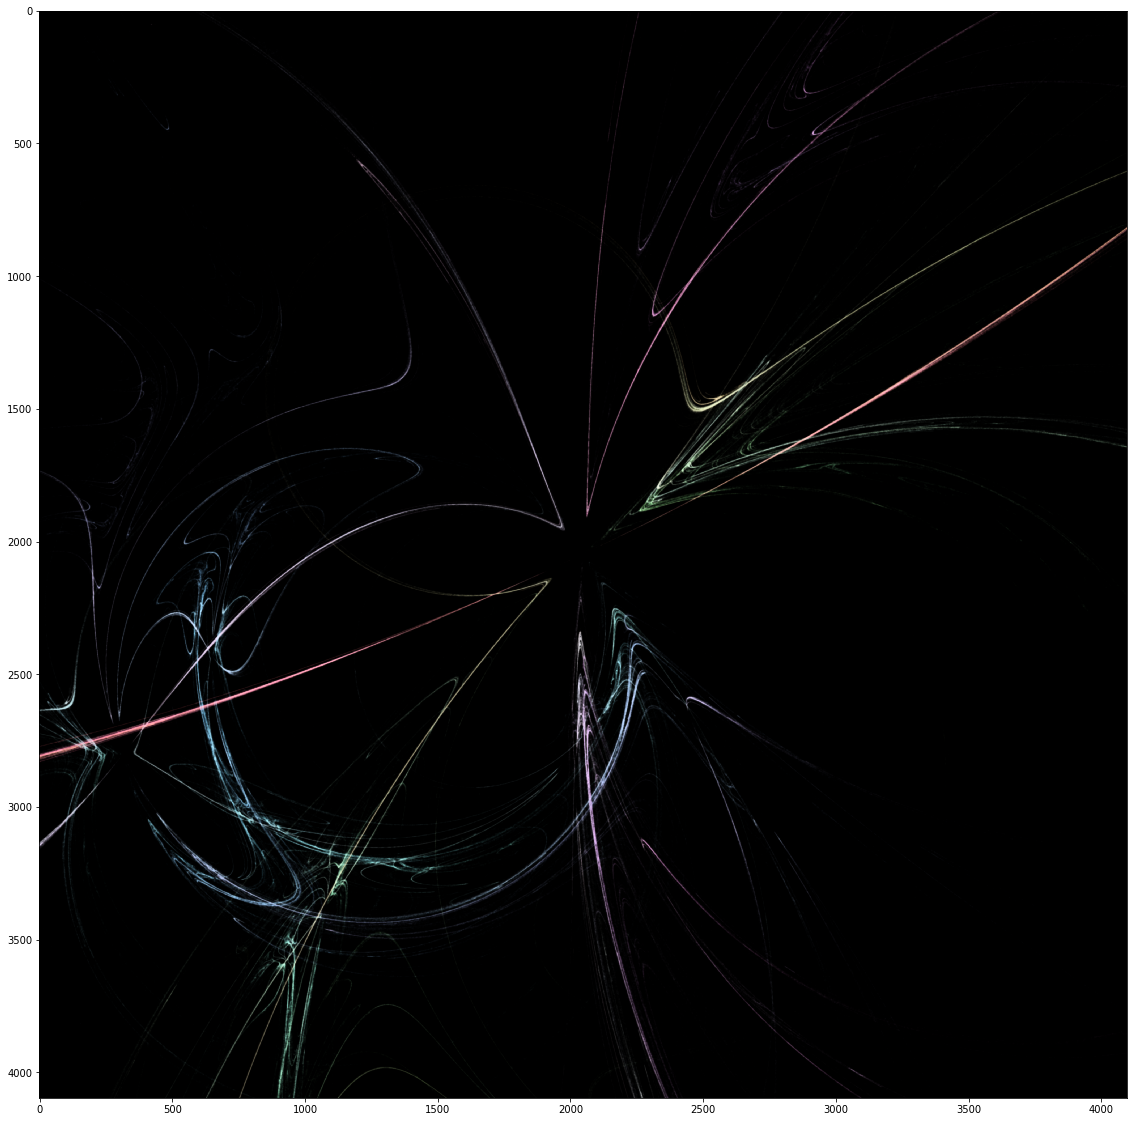

In [10]:
show_img(postprocessed_mat)

In [11]:
pickle.dump(mat, open('mat.dump', 'wb'))